### Machine Learning Workflow

This notebook predicts future price of Litecoin using sagemaker's built in pca model to reduce dimensionality
* Loading and exploring the data
* Data cleaning and pre-processing
* Dimensionality reduction of coinmetric's dataset's 32 features with PCA
* Feature engineering with data transformation
* Uploading data to S3
* Instantiating and training an XGBoost estimator
* Creating transformer and making predictions with test set
* Evaluating the predictions through simulating buying and selling Litecoin based on model predictions over test dataset

In [2]:
import boto3
import pandas as pd
from sagemaker import get_execution_role
import sagemaker
import os
import re
import numpy as np
import json
import matplotlib.pyplot as plt
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import seaborn as sns
import helpers
import sklearn.model_selection

In [3]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()


In [4]:
ltc_df = pd.read_csv('Data/ltc.csv')

In [5]:
ltc_df = ltc_df[1862:]

In [6]:
ltc_df.head()

,date,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,...,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d
1862,2016-11-11,7301,638,1962084,3075.366771,0.657791,1.844730e+08,2.804431e+08,53827.569370,0.006044,...,1.946260e+06,147.744617,563.151417,0.616035,2.348112,1.310052e+06,4.993464e+06,0.029249,0.016593,0.012424
1863,2016-11-12,10630,576,2417247,4196.609375,0.647167,1.814419e+08,2.803635e+08,53827.569370,0.007412,...,2.803788e+06,233.870536,876.525329,0.159891,0.599259,2.545915e+06,9.541855e+06,0.029240,0.016358,0.012601
1864,2016-11-13,15468,561,2550985,4547.210339,0.671392,1.882939e+08,2.804530e+08,57164.083717,0.004974,...,5.399170e+06,339.766758,1321.121208,0.013982,0.054368,6.012513e+06,2.337856e+07,0.029359,0.017770,0.013482
1865,2016-11-14,13481,605,2800901,4629.588430,0.667102,1.871896e+08,2.806010e+08,58578.291575,0.006038,...,3.757638e+06,234.939070,907.877015,0.028395,0.109729,3.063840e+06,1.183962e+07,0.029357,0.017801,0.013501
1866,2016-11-15,10544,588,2694323,4582.181973,0.673017,1.889013e+08,2.806781e+08,58578.291575,0.004643,...,4.545794e+06,392.344821,1529.540788,0.500000,1.949230,4.390339e+06,1.711556e+07,0.029131,0.017859,0.013542


In [7]:
ltc_df.describe()

,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,...,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d
count,1096.000000,1096.000000,1.096000e+03,1096.000000,1096.000000,1.096000e+03,1.096000e+03,1.096000e+03,1096.000000,1096.000000,...,1.096000e+03,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03,1.096000e+03,1096.000000,1096.000000,1096.000000
mean,82347.671533,583.525547,1.553022e+07,26713.676628,1.128844,4.177361e+09,4.055259e+09,5.878188e+06,0.002126,0.101910,...,7.875574e+07,116.613356,4343.717272,0.348153,22.752600,5.435004e+06,4.122967e+08,0.060007,0.057756,0.059037
std,65146.564702,42.820655,1.206080e+07,20762.551881,0.611669,3.353178e+09,2.482968e+09,4.824325e+06,0.002364,0.125679,...,1.288278e+08,189.714590,5905.877622,0.444998,33.910942,7.668855e+06,8.743193e+08,0.018699,0.026164,0.022898
min,7301.000000,425.000000,1.802586e+06,3075.366771,0.276605,1.706711e+08,2.803635e+08,5.382757e+04,0.000124,0.007243,...,9.787829e+05,3.287971,48.455170,0.000004,0.000239,3.567512e+05,1.359071e+06,0.020473,0.010154,0.012424
25%,53895.750000,559.000000,1.010088e+07,17602.551076,0.666747,1.951878e+09,1.359386e+09,4.428049e+05,0.000669,0.030592,...,2.017132e+07,18.267780,985.291229,0.127903,6.912045,1.396261e+06,5.505865e+07,0.047501,0.041734,0.043604
50%,74892.500000,582.000000,1.433502e+07,24667.656900,0.946673,3.417782e+09,4.725284e+09,6.281823e+06,0.001149,0.057452,...,4.053103e+07,35.302602,2107.171018,0.181917,11.639132,2.472262e+06,1.405189e+08,0.057153,0.050905,0.054035
75%,92713.750000,604.000000,1.752101e+07,30841.005489,1.504667,5.622037e+09,6.403594e+09,9.706633e+06,0.002783,0.136232,...,8.389766e+07,140.632538,4946.621876,0.361985,23.159581,5.829738e+06,3.898722e+08,0.079674,0.067608,0.073817
max,601822.000000,913.000000,1.199902e+08,204412.596252,4.052680,1.952270e+10,7.300978e+09,1.651091e+07,0.020992,1.436288,...,1.944886e+09,1991.118973,54361.806493,4.999000,253.263087,8.813091e+07,1.232047e+10,0.093568,0.141050,0.120042


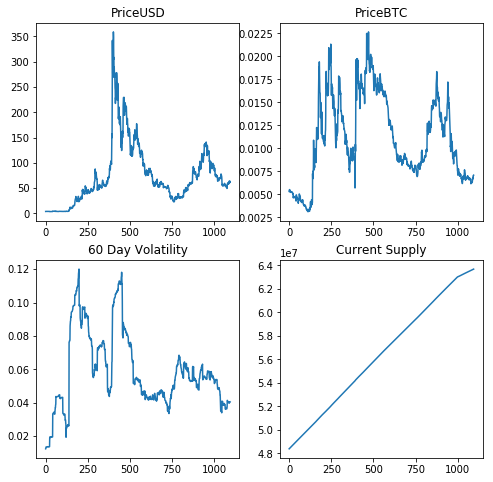

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
N=len(ltc_df)
ind = np.arange(N)

ax = axes[0,0]
ax.plot(ind, ltc_df['PriceUSD'])
ax.set_title('PriceUSD')

ax = axes[0,1]
ax.plot(ind, ltc_df['PriceBTC'])
ax.set_title('PriceBTC')

ax = axes[1,0]
ax.plot(ind, ltc_df['VtyDayRet60d'])
ax.set_title('60 Day Volatility')

ax = axes[1,1]
ax.plot(ind, ltc_df['SplyCur'])
ax.set_title('Current Supply')

plt.show()

In [9]:
ltc_df = ltc_df.drop(labels='date', axis=1)

In [10]:
ltc_df.shape

(1096, 39)

In [11]:
ltc_df.columns.values

array(['AdrActCnt', 'BlkCnt', 'BlkSizeByte', 'BlkSizeMeanByte',
       'CapMVRVCur', 'CapMrktCurUSD', 'CapRealUSD', 'DiffMean',
       'FeeMeanNtv', 'FeeMeanUSD', 'FeeMedNtv', 'FeeMedUSD', 'FeeTotNtv',
       'FeeTotUSD', 'IssContNtv', 'IssContPctAnn', 'IssContUSD',
       'IssTotNtv', 'IssTotUSD', 'NVTAdj', 'NVTAdj90', 'PriceBTC',
       'PriceUSD', 'ROI1yr', 'ROI30d', 'SplyCur', 'TxCnt', 'TxTfrCnt',
       'TxTfrValAdjNtv', 'TxTfrValAdjUSD', 'TxTfrValMeanNtv',
       'TxTfrValMeanUSD', 'TxTfrValMedNtv', 'TxTfrValMedUSD',
       'TxTfrValNtv', 'TxTfrValUSD', 'VtyDayRet180d', 'VtyDayRet30d',
       'VtyDayRet60d'], dtype=object)

In [12]:
ltc_df.insert(39, 'Label', 0.0)

In [13]:
ltc_df.shape

(1096, 40)

In [14]:
ltc_df.index = np.arange(len(ltc_df))

In [15]:
ltc_df.head()

,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,...,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,Label
0,7301,638,1962084,3075.366771,0.657791,1.844730e+08,2.804431e+08,53827.569370,0.006044,0.023037,...,147.744617,563.151417,0.616035,2.348112,1.310052e+06,4.993464e+06,0.029249,0.016593,0.012424,0.0
1,10630,576,2417247,4196.609375,0.647167,1.814419e+08,2.803635e+08,53827.569370,0.007412,0.027780,...,233.870536,876.525329,0.159891,0.599259,2.545915e+06,9.541855e+06,0.029240,0.016358,0.012601,0.0
2,15468,561,2550985,4547.210339,0.671392,1.882939e+08,2.804530e+08,57164.083717,0.004974,0.019340,...,339.766758,1321.121208,0.013982,0.054368,6.012513e+06,2.337856e+07,0.029359,0.017770,0.013482,0.0
3,13481,605,2800901,4629.588430,0.667102,1.871896e+08,2.806010e+08,58578.291575,0.006038,0.023331,...,234.939070,907.877015,0.028395,0.109729,3.063840e+06,1.183962e+07,0.029357,0.017801,0.013501,0.0
4,10544,588,2694323,4582.181973,0.673017,1.889013e+08,2.806781e+08,58578.291575,0.004643,0.018100,...,392.344821,1529.540788,0.500000,1.949230,4.390339e+06,1.711556e+07,0.029131,0.017859,0.013542,0.0


In [16]:
for i in range(len(ltc_df)):
    if i < (len(ltc_df)-1):
        ltc_df['Label'][i] = ltc_df['PriceUSD'][i+1]
    else:
        ltc_df['Label'][i] = ltc_df['PriceUSD'][i]

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [135]:
ltc_df.head()

,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,...,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,Label
0,7301,638,1962084,3075.366771,0.657791,1.844730e+08,2.804431e+08,53827.569370,0.006044,0.023037,...,147.744617,563.151417,0.616035,2.348112,1.310052e+06,4.993464e+06,0.029249,0.016593,0.012424,3.747908
1,10630,576,2417247,4196.609375,0.647167,1.814419e+08,2.803635e+08,53827.569370,0.007412,0.027780,...,233.870536,876.525329,0.159891,0.599259,2.545915e+06,9.541855e+06,0.029240,0.016358,0.012601,3.888318
2,15468,561,2550985,4547.210339,0.671392,1.882939e+08,2.804530e+08,57164.083717,0.004974,0.019340,...,339.766758,1321.121208,0.013982,0.054368,6.012513e+06,2.337856e+07,0.029359,0.017770,0.013482,3.864308
3,13481,605,2800901,4629.588430,0.667102,1.871896e+08,2.806010e+08,58578.291575,0.006038,0.023331,...,234.939070,907.877015,0.028395,0.109729,3.063840e+06,1.183962e+07,0.029357,0.017801,0.013501,3.898460
4,10544,588,2694323,4582.181973,0.673017,1.889013e+08,2.806781e+08,58578.291575,0.004643,0.018100,...,392.344821,1529.540788,0.500000,1.949230,4.390339e+06,1.711556e+07,0.029131,0.017859,0.013542,3.909259


In [18]:
X_df = pd.DataFrame(ltc_df.drop(labels='Label', axis=1))
Y_df = pd.DataFrame(ltc_df['Label'])

# Now for PCA

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

ltc_scaled = pd.DataFrame(scaler.fit_transform(ltc_df.astype(float)))

ltc_scaled.columns = ltc_df.columns

In [41]:
ltc_scaled.head()

,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,...,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,Label
0,0.000000,0.436475,0.001350,0.000000,0.100948,0.000713,0.000011,0.000000,0.283679,0.011052,...,0.072670,0.009476,0.123231,0.009270,0.010861,0.000295,0.120063,0.049191,0.000000,0.000695
1,0.005599,0.309426,0.005201,0.005569,0.098134,0.000557,0.000000,0.000000,0.349245,0.014371,...,0.115997,0.015246,0.031984,0.002365,0.024941,0.000664,0.119938,0.047399,0.001640,0.001090
2,0.013737,0.278689,0.006332,0.007310,0.104549,0.000911,0.000013,0.000203,0.232397,0.008465,...,0.169269,0.023432,0.002796,0.000214,0.064435,0.001787,0.121567,0.058187,0.009828,0.001022
3,0.010395,0.368852,0.008447,0.007719,0.103414,0.000854,0.000034,0.000289,0.283373,0.011258,...,0.116535,0.015823,0.005679,0.000432,0.030842,0.000851,0.121535,0.058422,0.010009,0.001118
4,0.005455,0.334016,0.007545,0.007484,0.104980,0.000942,0.000045,0.000289,0.216537,0.007597,...,0.195719,0.027269,0.100019,0.007696,0.045954,0.001279,0.118448,0.058861,0.010389,0.001148


In [42]:
ltc_scaled.describe()

,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,...,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,Label
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,...,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,0.126230,0.324847,0.116151,0.117407,0.225694,0.207042,0.537687,0.353912,0.095952,0.066245,...,0.057010,0.079083,0.069644,0.089837,0.057856,0.033358,0.540858,0.363661,0.433135,0.195206
std,0.109578,0.087747,0.102048,0.103123,0.161985,0.173273,0.353668,0.293146,0.113288,0.087946,...,0.095438,0.108737,0.089017,0.133896,0.087370,0.070973,0.255825,0.199887,0.212768,0.168718
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.078374,0.274590,0.070213,0.072153,0.103319,0.092042,0.153693,0.023636,0.026111,0.016339,...,0.007536,0.017249,0.025585,0.027291,0.011843,0.004359,0.369756,0.241262,0.289726,0.082300
50%,0.113691,0.321721,0.106038,0.107244,0.177451,0.167792,0.633124,0.378438,0.049104,0.035135,...,0.016105,0.037904,0.036390,0.045956,0.024102,0.011296,0.501808,0.311324,0.386648,0.152311
75%,0.143666,0.366803,0.132996,0.137906,0.325222,0.281695,0.872179,0.586544,0.127412,0.090262,...,0.069093,0.090183,0.072411,0.091444,0.062353,0.031537,0.809923,0.438929,0.570467,0.250453
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
ltc_scaled_pca = ltc_scaled.drop('Label', axis=1)

In [44]:
prefix = 'ltc_pca'

output_path = 's3://{}/{}/'.format(bucket, prefix)

In [45]:
from sagemaker import PCA

n_comps = ltc_scaled_pca.shape[1] - 1

pca = PCA(role=role,
         train_instance_count=1,
         train_instance_type='ml.c4.xlarge',
         output_path=output_path,
         num_components=n_comps,
         sagemaker_session=sagemaker_session)

In [46]:
train_data = ltc_scaled_pca.values.astype('float32')

formatted_train_data = pca.record_set(train_data)

In [47]:
%%time

pca.fit(formatted_train_data)

2019-12-27 19:38:42 Starting - Starting the training job...
2019-12-27 19:38:43 Starting - Launching requested ML instances......
2019-12-27 19:39:46 Starting - Preparing the instances for training......
2019-12-27 19:41:02 Downloading - Downloading input data
2019-12-27 19:41:02 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[12/27/2019 19:41:23 INFO 140539394279232] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[12/27/2019 19:41:23 INFO 140539394279232] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'39', u'mini_batch_size': u'500', u'num_components': u'38'}
[12/27/2019 19:41:23 INFO 140539394279232


2019-12-27 19:41:31 Uploading - Uploading generated training model
2019-12-27 19:41:31 Completed - Training job completed
Training seconds: 45
Billable seconds: 45
CPU times: user 379 ms, sys: 3.89 ms, total: 383 ms
Wall time: 3min 11s


In [48]:
training_job_name = 'pca-2019-12-27-19-38-41-877'

model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')

os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

ltc_pca/pca-2019-12-27-19-38-41-877/output/model.tar.gz


2304

After the model is unzipped and decompressed, we can load the array using MXNet.

You can take a look at the MXNet [documentation, here](https://aws.amazon.com/mxnet/).

In [49]:
import mxnet as mx

pca_model_params = mx.ndarray.load('model_algo-1')

print(pca_model_params)

{'s': 
[        nan  0.05195354  0.07221646  0.12039712  0.17630288  0.25362486
  0.30457464  0.36747524  0.38020214  0.41898     0.4520264   0.52687943
  0.7191512   0.9000087   0.9728602   1.0273622   1.1615984   1.2192763
  1.3392622   1.46746     1.617368    1.7524611   2.0369804   2.1891592
  2.5481617   2.5585327   2.7827265   3.2644804   3.5846558   3.8154154
  4.4355016   4.6557965   5.4621005   7.7980704   8.147463    8.568071
 18.898195   20.124832  ]
<NDArray 38 @cpu(0)>, 'v': 
[[ 0.00000000e+00  7.60781346e-03  7.46134343e-03 ... -8.88627395e-02
   8.80259871e-02 -1.28792450e-01]
 [-2.97973966e-13  2.64746118e-02 -9.66426358e-02 ... -1.97411031e-02
   4.84057628e-02  1.10137612e-02]
 [ 1.34449353e-12 -1.86690390e-01  6.17613256e-01 ... -5.26554659e-02
   6.37305304e-02 -1.15812205e-01]
 ...
 [ 2.96695990e-14  8.69471394e-03  8.49026907e-03 ...  2.38118693e-01
   3.11412871e-01 -1.83551833e-01]
 [-3.44494758e-15 -1.72542420e-03  1.23593025e-03 ...  3.39725465e-01
   2.493104

## PCA Model Attributes

Three types of model attributes are contained within the PCA model.

* **mean**: The mean that was subtracted from a component in order to center it.
* **v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
* **s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
    
We are only interested in v and s. 

From s, we can get an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for _all_ components:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

From v, we can learn more about the combinations of original features that make up each principal component.

In [50]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

The original 39 features captured 100% of the variance in our data. Now we'll discard components until we are covering just over 80% of the variance.

The top principal components are located at the end of the s DataFrame. 

The below function, **explained_variance**, receives the s DataFrame and the number of principal components as input to return the explained variance. 

For example, to calculate the explained variance for the top 5 components, calculate s squared for *each* of the top 5 components, add those up and normalize by the sum of *all* squared s values, according to this formula:

\begin{equation*}
\frac{\sum_{5}^{ } s_n^2}{\sum s^2}
\end{equation*}

In [51]:
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = len(s) - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]


Remember, we're aiming to cover around 80% of the variance.

In [54]:
n_components = 11

exp_variance = explained_variance(s, n_components)
print('Explained variance for {} components is {}.'.format(n_components, exp_variance))

Explained variance for 11 components is 0.9582797884941101.


#### Component Makeup

Now we'll take a look at the makeup of the PCA components based on the weights of the original features that are included in the component.

In [55]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = (len(v)-1)-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Greens_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

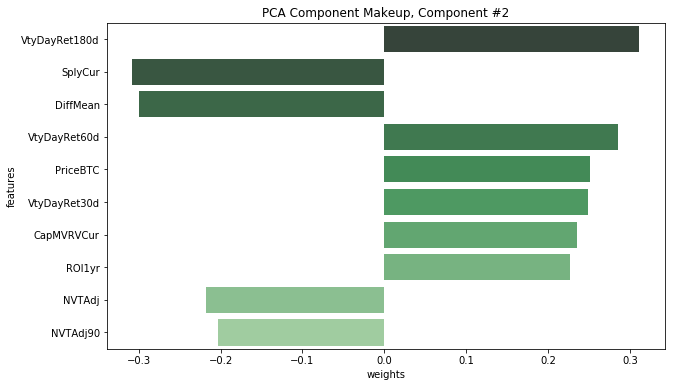

In [56]:
display_component(v, ltc_scaled_pca.columns.values, component_num=2, n_weights=10)

In [57]:
%%time

pca_predictor = pca.deploy(initial_instance_count=1,
                          instance_type='ml.c4.xlarge')

---------------------------------------------------------------------------------------------------------------!CPU times: user 560 ms, sys: 21.9 ms, total: 582 ms
Wall time: 9min 20s


In [58]:
train_pca = pca_predictor.predict(train_data)

In [59]:
def create_transformed_df(train_pca, ltc_scaled_pca, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param ltc_scaled_pca: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, with n_top_component values as columns.        
     '''
    # create new dataframe to add data to
    ltc_pca_transformed=pd.DataFrame()

    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components=data.label['projection'].float32_tensor.values
        ltc_pca_transformed=ltc_pca_transformed.append([list(components)])

    # keep only the top n components
    start_idx = (ltc_scaled_pca.shape[1]-1) - n_top_components
    ltc_pca_transformed = ltc_pca_transformed.iloc[:,start_idx:]
    
    # reverse columns, component order     
    return ltc_pca_transformed.iloc[:, ::-1]

In [81]:
ltc_pca_df = create_transformed_df(train_pca, ltc_scaled_pca, n_top_components=11)

PCA_list = ['c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9', 'c_10', 'c_11']
ltc_pca_df.columns=PCA_list
ltc_pca_df.index = np.arange(len(train_pca))


ltc_pca_df.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11
0,1.143233,-0.198128,-0.495160,-0.103260,-0.130133,-0.068063,0.144190,-0.076503,-0.064265,0.077346,-0.032370
1,1.143155,-0.219435,-0.453729,0.045834,-0.098951,-0.058222,0.151311,-0.098779,0.096556,0.055343,-0.032988
2,1.130791,-0.197645,-0.399433,0.083292,-0.107511,-0.100089,0.125544,-0.060309,0.170976,0.052356,0.029762
3,1.140207,-0.184081,-0.448605,-0.021109,-0.128337,-0.097673,0.106156,-0.085063,0.080598,0.073041,0.010456
4,1.142366,-0.181537,-0.410638,0.023287,-0.125464,-0.122912,0.121870,-0.037515,0.119741,0.052653,0.015130


In [82]:
def train_test_split(df, ratio, Y_train, Y_test):
    df_matrix = df.values
    
    train_size = int(df_matrix.shape[0] * ratio)
    X_train = df_matrix[:train_size,:]
    
    X_test = df_matrix[train_size:,:]
    
    return (X_train, Y_train), (X_test, Y_test)

In [85]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_df, Y_df, test_size=0.1, shuffle=False)

In [86]:
(X_train, Y_train), (X_test, Y_test) = train_test_split(ltc_pca_df, ratio=.9, Y_train=Y_train, Y_test=Y_test)

In [87]:
len(X_train)

986

In [88]:
assert len(X_train) == len(Y_train), \
    'Train lengths aren\'t equal'
assert len(X_test) == len(Y_test), \
    'Test lengths aren\'t equal'

print('Tests Passed!')    

Tests Passed!


In [89]:
data_dir = 'Data/pca_ltc_11c'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [90]:
pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([pd.DataFrame(Y_train), pd.DataFrame(X_train)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [91]:
prefix = 'ltc-pca-xgboost'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [92]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=sagemaker_session) # The current SageMaker session

In [93]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [94]:
s3_train_input = sagemaker.s3_input(s3_data=train_location, content_type='csv')

xgb.fit({'train': s3_train_input})

2019-12-27 20:07:41 Starting - Starting the training job...
2019-12-27 20:07:42 Starting - Launching requested ML instances......
2019-12-27 20:08:45 Starting - Preparing the instances for training......
2019-12-27 20:09:49 Downloading - Downloading input data...
2019-12-27 20:10:40 Training - Training image download completed. Training in progress.
2019-12-27 20:10:40 Uploading - Uploading generated training model.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[20:10:37] 986x11 matrix with 10846 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,


2019-12-27 20:10:47 Completed - Training job completed
Training seconds: 58
Billable seconds: 58


In [95]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [96]:
xgb_transformer.wait()

.......................[2019-12-27 20:16:05 +0000] [14] [INFO] Starting gunicorn 19.10.0
[2019-12-27 20:16:05 +0000] [14] [INFO] Listening at: unix:/tmp/gunicorn.sock (14)
[2019-12-27 20:16:05 +0000] [14] [INFO] Using worker: gevent
[2019-12-27 20:16:05 +0000] [21] [INFO] Booting worker with pid: 21
[2019-12-27 20:16:05 +0000] [22] [INFO] Booting worker with pid: 22
[2019-12-27 20:16:05 +0000] [23] [INFO] Booting worker with pid: 23
[2019-12-27 20:16:05 +0000] [24] [INFO] Booting worker with pid: 24
[2019-12-27:20:16:26:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [27/Dec/2019:20:16:26 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [27/Dec/2019:20:16:26 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2019-12-27:20:16:26:INFO] Determined delimiter of CSV input is ','
[20:16:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
169.254

In [97]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-561941966718/sagemaker-xgboost-2019-12-27-20-12-41-377/test.csv.out to Data/pca_ltc_11c/test.csv.out


In [98]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [99]:
helpers.get_test_loss(Y_pred, Y_test)

Test loss is 7.467957743563383.


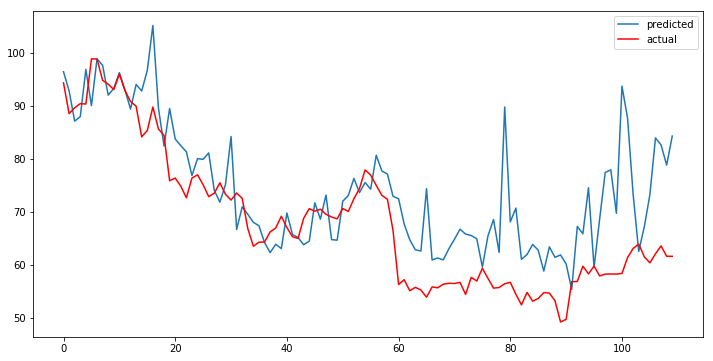

In [100]:
plt.figure(figsize=(12,6))
plt.plot(range(len(Y_pred)), Y_pred, label='predicted')
plt.plot(range(len(Y_pred)), Y_test, color='r', label='actual')
plt.legend()
plt.show()

In [133]:
helpers.roi_display(20000, Y_pred, Y_test)

Investing $20000.00
Holding $20155.07
Investing $20155.07
Holding $20151.40
Investing $20151.40
Holding $20557.43
Investing $20557.43
Holding $20353.65
Investing $20353.65
Holding $21711.41
Investing $21711.41
Holding $19520.56
Investing $19520.56
Holding $19676.64
Investing $19676.64
Holding $19091.00
Investing $19091.00
Holding $18267.50
Investing $18267.50
Holding $18015.90
Investing $18015.90
Holding $18211.84
Investing $18211.84
Holding $17651.84
Investing $17651.84
Holding $17996.06
Investing $17996.06
Holding $17755.90
Investing $17755.90
Holding $18733.64
Investing $18733.64
Holding $19616.23
Investing $19616.23
Holding $19120.11
Investing $19120.11
Holding $18657.59
Investing $18657.59
Holding $18603.78
Investing $18603.78
Holding $18715.27
Investing $18715.27
Holding $17539.40
Investing $17539.40
Holding $17762.58
Investing $17762.58
Holding $17059.96
Investing $17059.96
Holding $17286.19
Investing $17286.19
Holding $17256.97
Investing $17256.97
Holding $15963.01
Investing $1

In [134]:
# delete predictor endpoint
sagemaker_session.delete_endpoint(pca_predictor.endpoint)